In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'customer-churn-prediction-2020:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F20144%2F1113024%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240323%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240323T081423Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9c4308f3bb5b67eb51f12cdb2ab2ffbb647233d3ffbd331cd893ddafffa8e0131549a65aa9b5a67370a837d578ee75d3dd037c0e799bfb0480b234ca67af7e7e7cd1209cb369bcc54329cda98ed49e94776f4a6a5a6c3e455dd7d9234aff4dd89703525b3abdaf0b02ade79de136c58b34bc2a65a8bd464c43c2b06e6f7ecf6dc065a8b86922aab3d8b9ebca9568ac35df4c3bd2254b9384d9814358d505fd88d063704ca49bf2d84e6a63542b94d42849da18fbf6cdb2775d5aa255d0f5278442d807906a32075b28ad0c235c3df493bdba3a8dc294c796ad229ca510f14d2179c32f9032f4719f99f80a59bd0e553bd1ece1b270cbb9c0cff88fcead9a7845'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 157198 bytes downloaded
Downloaded and uncompressed: customer-churn-prediction-2020
Data source import complete.


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold,RepeatedStratifiedKFold,GridSearchCV,cross_val_score
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### About the dataset
* state: string. 2-letter code of the US state of customer residence
* account_length: numerical. Number of months the customer has been with the current telco provider
* area_code: string="area_code_AAA" where AAA = 3 digit area code.
* international_plan: (yes/no). The customer has international plan.
* voice_mail_plan: (yes/no). The customer has voice mail plan.
* number_vmail_messages: numerical. Number of voice-mail messages.
* total_day_minutes: numerical. Total minutes of day calls.
* total_day_calls: numerical. Total number of day calls.
* total_day_charg: numerical. Total charge of day calls.
* total_eve_minutes: numerical. Total minutes of evening calls.
* total_eve_calls: numerical. Total number of evening calls.
* total_eve_charge: numerical. Total charge of evening calls.
* total_night_minutes: numerical. Total minutes of night calls.
* total_night_calls: numerical. Total number of night calls.
* total_night_charge: numerical. Total charge of night calls.
* total_intl_minutes: numerical. Total minutes of international calls.
* total_intl_calls: numerical. Total number of international calls.
* total_intl_charge: numerical. Total charge of international calls
* number_customer_service_calls: numerical. Number of calls to customer service
* churn: (yes/no) Customer churn - target variable.

In [5]:
#Read the dataset
df = pd.read_csv("/content/train (1).csv")

In [7]:
# The data set on which the prediction will be done and result will be submitted for evaluation.
test = pd.read_csv('/content/test (1).csv')

In [8]:
# first 5 records from the dataset
df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   object 
 1   account_length                 4250 non-null   int64  
 2   area_code                      4250 non-null   object 
 3   international_plan             4250 non-null   object 
 4   voice_mail_plan                4250 non-null   object 
 5   number_vmail_messages          4250 non-null   int64  
 6   total_day_minutes              4250 non-null   float64
 7   total_day_calls                4250 non-null   int64  
 8   total_day_charge               4250 non-null   float64
 9   total_eve_minutes              4250 non-null   float64
 10  total_eve_calls                4250 non-null   int64  
 11  total_eve_charge               4250 non-null   float64
 12  total_night_minutes            4250 non-null   f

In [10]:
df.describe()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
count,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000
mean,100.236235,7.631765,180.259600,99.907294,30.644682,200.173906,100.176471,17.015012,200.527882,99.839529,9.023892,10.256071,4.426353,2.769654,1.559059
std,39.698401,13.439882,54.012373,19.850817,9.182096,50.249518,19.908591,4.271212,50.353548,20.093220,2.265922,2.760102,2.463069,0.745204,1.311434
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,73.000000,0.000000,143.325000,87.000000,24.365000,165.925000,87.000000,14.102500,167.225000,86.000000,7.522500,8.500000,3.000000,2.300000,1.000000
50%,100.000000,0.000000,180.450000,100.000000,30.680000,200.700000,100.000000,17.060000,200.450000,100.000000,9.020000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,16.000000,216.200000,113.000000,36.750000,233.775000,114.000000,19.867500,234.700000,113.000000,10.560000,12.000000,6.000000,3.240000,2.000000
max,243.000000,52.000000,351.500000,165.000000,59.760000,359.300000,170.000000,30.540000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [11]:
#Function to get summary statistics for categorical variable.

def dataQuality(data):
    d={}
    def cat_quality(data):
        def count(x):
            return x.count()
        def miss_per(x):
            return x.isnull().sum()/len(x)
        def unique(x):
            return len(x.unique())
        def freq_cat(x):
            return x.value_counts().sort_values(ascending=False).index[0]
        def freq_cat_per(x):
            return x.value_counts().sort_values(ascending=False).index[0]/len(x)
        qr=dict()
        #select only categorical data types
        data=data.select_dtypes(include=[object])
        for i in np.arange(0,len(data.columns),1):
            xi=data.agg({data.columns[i]:[count,unique,miss_per,freq_cat]})
            qr[data.columns[i]]=xi.reset_index(drop=True)[data.columns[i]]
            df2=pd.DataFrame(qr)
            #df2.index=xi.index
        df2.index=["Count","Unique","Miss_percent","Freq_Level"]
        return df2.T
    d['categorical']=cat_quality(data)
    return d

In [12]:
(dataQuality(df)['categorical'])

,Count,Unique,Miss_percent,Freq_Level
state,4250,51,0.0,WV
area_code,4250,3,0.0,area_code_415
international_plan,4250,2,0.0,no
voice_mail_plan,4250,2,0.0,no
churn,4250,2,0.0,no


<ipython-input-13-8f213a9f233e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  splot=sns.countplot(data=df,x='churn',palette='GnBu')


Text(0, 0.5, 'Number of customers')

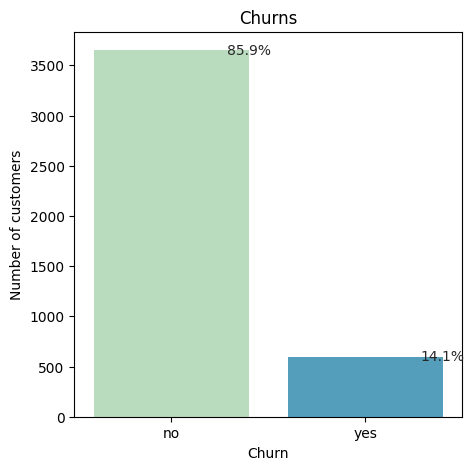

In [13]:
plt.figure(figsize=(5,5))
splot=sns.countplot(data=df,x='churn',palette='GnBu')
sns.set_style('ticks')
total = float(len(df))
for p in splot.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    splot.annotate(percentage,(x,y),ha = 'center', va = 'center')
plt.title("Churns")
plt.xlabel("Churn")
plt.ylabel("Number of customers")

#### We can see from the data that 14% of the population have churned.

<ipython-input-14-b7a45fbdeb29>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(data=df[['account_length','churn']],x='churn',y='account_length',kind="box",palette='GnBu')


Text(5.069444444444445, 0.5, 'Number of months with operator')

<Figure size 500x500 with 0 Axes>

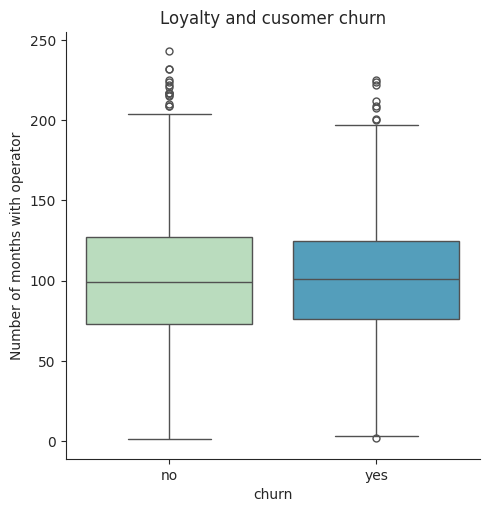

In [14]:
plt.figure(figsize=(5,5))
sns.catplot(data=df[['account_length','churn']],x='churn',y='account_length',kind="box",palette='GnBu')
plt.title("Loyalty and cusomer churn")
plt.ylabel("Number of months with operator")

#### From the above box plot we dont see any specific behavious of account_length for customers who churned and who did not.

<ipython-input-15-fea609297c96>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(data=df[['total_day_charge','churn']],x='churn',y='total_day_charge',kind="box",palette='GnBu')
<ipython-input-15-fea609297c96>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(data=df[['total_eve_charge','churn']],x='churn',y='total_eve_charge',kind="box",palette='GnBu')
<ipython-input-15-fea609297c96>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(data=df[['total_night_charge','churn']],x='churn',y='total_night_charge',kind="box",palette='GnBu')
<ipython-inp

Text(22.569444444444443, 0.5, 'Call charges in USD')

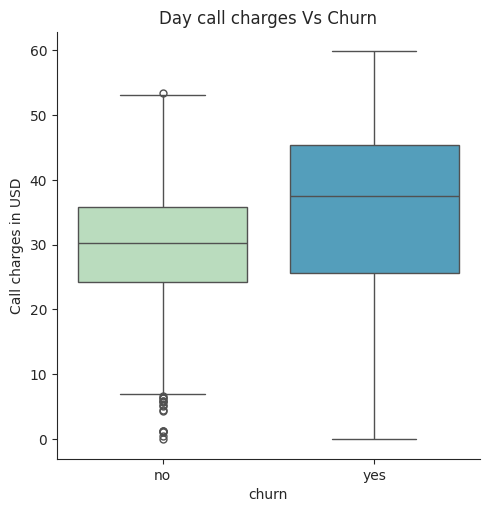

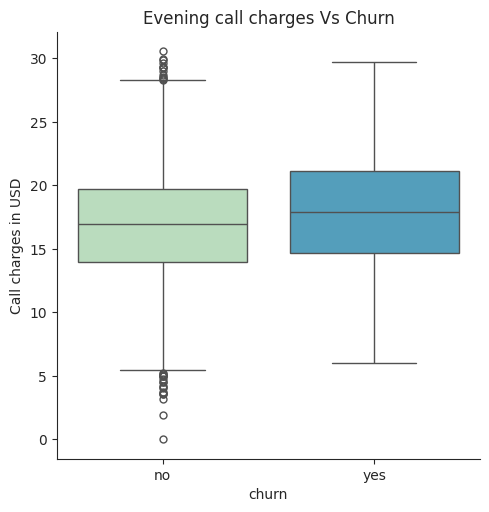

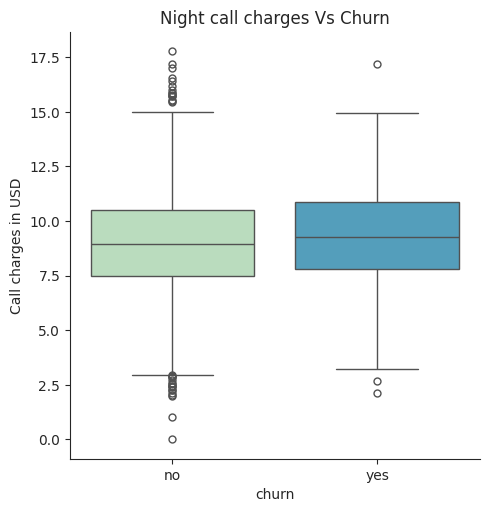

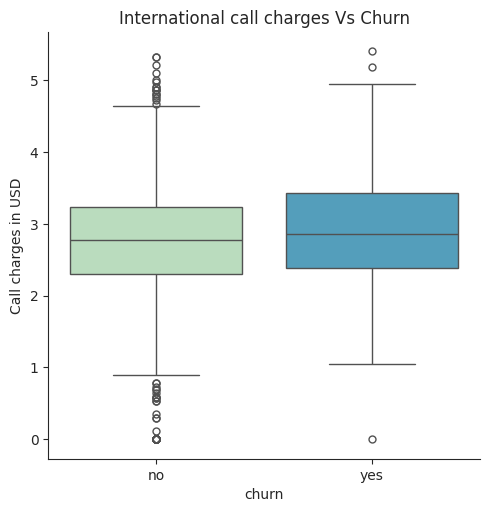

In [15]:
sns.catplot(data=df[['total_day_charge','churn']],x='churn',y='total_day_charge',kind="box",palette='GnBu')
plt.title("Day call charges Vs Churn")
plt.ylabel("Call charges in USD")

sns.catplot(data=df[['total_eve_charge','churn']],x='churn',y='total_eve_charge',kind="box",palette='GnBu')
plt.title("Evening call charges Vs Churn")
plt.ylabel("Call charges in USD")

sns.catplot(data=df[['total_night_charge','churn']],x='churn',y='total_night_charge',kind="box",palette='GnBu')
plt.title("Night call charges Vs Churn")
plt.ylabel("Call charges in USD")

sns.catplot(data=df[['total_intl_charge','churn']],x='churn',y='total_intl_charge',kind="box",palette='GnBu')
plt.title("International call charges Vs Churn")
plt.ylabel("Call charges in USD")

#### Conclusion:
From the above box-plots we could see that the average 'day call charges' are more for the customers who churned.\
This can be one of the significant reasons why most of the customers have left.\
For rest of the call charges the behaviour is more or less same for customers who have churned and who have not.

### Which locations have the maximum number of customer churns?

In [16]:
# creaet a dataframe containing states and count of customer churns those states.
state_count1=df[['state','churn']]
state_churn=state_count1[state_count1['churn']== 'yes'].groupby('state',as_index = False).count()

state_count2=df[['state','churn']].groupby('state',as_index = False).count()
state_count2.rename(columns={"churn":"total_cust"},inplace=True)

state_churn['total_cust']=state_count2['total_cust']
state_churn['%churn']=state_churn['churn']/state_count2['total_cust']

In [17]:
# Coropleth
fig = go.Figure(data=go.Choropleth(
    locations=state_churn['state'], # Spatial coordinates
    z = state_churn['%churn'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'GnBu',
    colorbar_title = "churn percentage",
))

fig.update_layout(
    title_text = 'Customer churns by State',
    geo_scope='usa', # limit map scope to USA
)

fig.show()

#### Conclusion:
New Jersey has the maximum percentage of customer churns (27%) followed by California (25%) and Washington(22%)


### Which area code have the maximum customer churns?

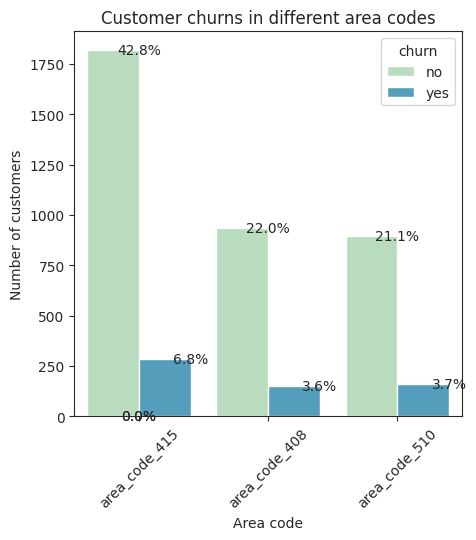

In [18]:
plt.figure(figsize=(5,5))
splot=sns.countplot(data=df,x='area_code',palette='GnBu',hue = 'churn')
sns.set_style('ticks')
total = float(len(df))
for p in splot.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    splot.annotate(percentage,(x,y),ha = 'center', va = 'center')
plt.title("Customer churns in different area codes")
plt.xlabel('Area code')
plt.ylabel('Number of customers')
plt.xticks(rotation=45)
plt.show()

#### Concluion:
Area code 415 has the maximum customer churn of 6.8%

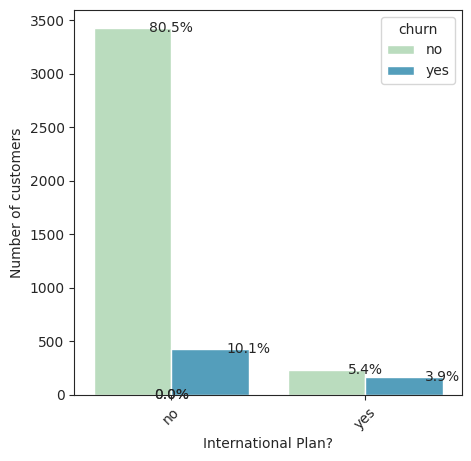

In [19]:
plt.figure(figsize=(5,5))
splot=sns.countplot(data=df,x='international_plan',palette='GnBu',hue = 'churn')
sns.set_style('ticks')
total = float(len(df))
for p in splot.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    splot.annotate(percentage,(x,y),ha = 'center', va = 'center')
plt.xlabel('International Plan?')
plt.ylabel('Number of customers')
plt.xticks(rotation=45)
plt.show()

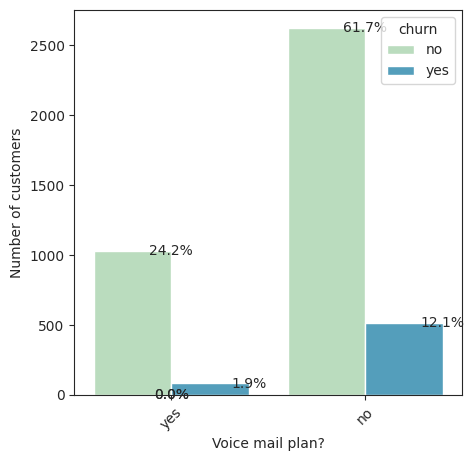

In [20]:
plt.figure(figsize=(5,5))
splot=sns.countplot(data=df,x='voice_mail_plan',palette='GnBu',hue = 'churn')
sns.set_style('ticks')
total = float(len(df))
for p in splot.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    splot.annotate(percentage,(x,y),ha = 'center', va = 'center')
plt.xlabel('Voice mail plan?')
plt.ylabel('Number of customers')
plt.xticks(rotation=45)
plt.show()

### Does customer service calls have impact on churn?

<ipython-input-21-a5b70a42d968>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




Text(22.569444444444443, 0.5, 'Number of customer support calls')

<Figure size 500x500 with 0 Axes>

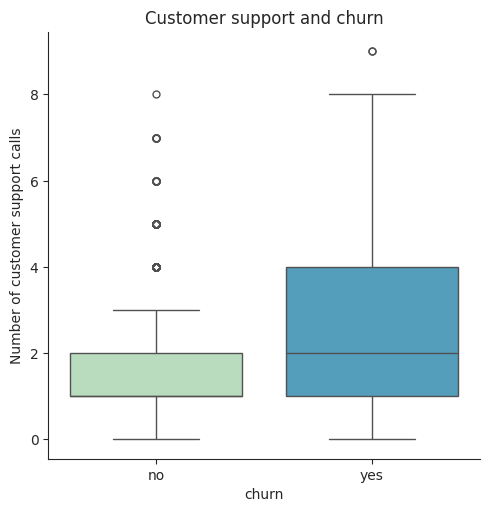

In [21]:
plt.figure(figsize=(5,5))
sns.catplot(data=df[['number_customer_service_calls','churn']],x='churn',y='number_customer_service_calls',kind="box",palette='GnBu')
plt.title("Customer support and churn")
plt.ylabel("Number of customer support calls")

#### Conclusion:
It seems that the customers who have not been assisted properly by the customer service agents for the resolution of issues have finally churned. More than 50% of the churned customers had called customer service at least twice and the maximum mumber of calls being 9.

In [22]:
df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


### Convert yes and no values to 1 and 0

In [23]:
df['international_plan'] = np.where(df['international_plan'].str.contains('yes'), 1, 0)
df['voice_mail_plan'] = np.where(df['voice_mail_plan'].str.contains('yes'), 1, 0)
df['churn'] = np.where(df['churn'].str.contains('yes'), 1, 0)

# Do the same for our test set
test['international_plan'] = np.where(test['international_plan'].str.contains('yes'), 1, 0)
test['voice_mail_plan'] = np.where(test['voice_mail_plan'].str.contains('yes'), 1, 0)

In [24]:
df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
1,NJ,137,area_code_415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
2,OH,84,area_code_408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
3,OK,75,area_code_415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0
4,MA,121,area_code_510,0,1,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,0


In [25]:
test.head()

,id,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,1,KS,128,area_code_415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,2,AL,118,area_code_510,1,0,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0
2,3,IA,62,area_code_415,0,0,0,120.7,70,20.52,307.2,76,26.11,203.0,99,9.14,13.1,6,3.54,4
3,4,VT,93,area_code_510,0,0,0,190.7,114,32.42,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3
4,5,NE,174,area_code_415,0,0,0,124.3,76,21.13,277.1,112,23.55,250.7,115,11.28,15.5,5,4.19,3


In [26]:
# get X and y from the dataset
X=df.drop('churn',axis=1)
y = df[['churn']]
X.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,OH,107,area_code_415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
1,NJ,137,area_code_415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
2,OH,84,area_code_408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
3,OK,75,area_code_415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3
4,MA,121,area_code_510,0,1,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3


### One hot encoding to create dummy variables

In [27]:
X=pd.get_dummies(X,columns=['state','area_code'])
test=pd.get_dummies(test,columns=['state','area_code'])

### Splitting the data set to train and test

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=41)

### SMOTE with  to handle imbalanced data set
As we have an imbalanced dataset with 86 percent data where customer has not churned, the model prediction might get biased. If a model only predicts that the customers have not churned, then the accuracy of the model would be 86%. To get the dataset balanced we have implemented SMOTE.
We first oversampled the minority class and then undersampled the majority class

In [29]:
over=SMOTE(sampling_strategy = 0.2)
under=RandomUnderSampler(sampling_strategy=0.6)
steps=[('o',over),('u',under)]
pipeline=Pipeline(steps=steps)
X_train,y_train=pipeline.fit_resample(X_train,y_train)

<ipython-input-30-19c965c5b6b7>:1: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




<Axes: xlabel='churn', ylabel='count'>

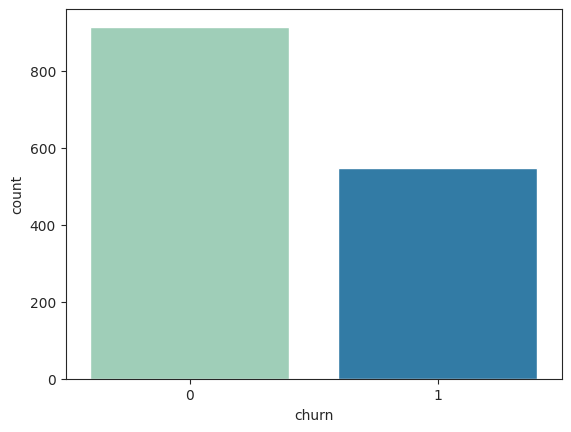

In [30]:
sns.countplot(x='churn',data=y_train,palette='YlGnBu')

### Logistic Regression

In [31]:
# define model
model = LogisticRegression()
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
# define search
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=cv)
# execute search
result = search.fit(X_train, y_train['churn'])

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


720 fits failed out of a total of 1440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 71, in _check_solver
    raise ValueError("penalty='non

In [32]:
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.7893855096856638
Best Hyperparameters: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}


In [33]:
# Accuracy
print("score of the LogisticRegression: ",result.score(X_test,y_test))

score of the LogisticRegression:  0.8353715898400753


### Random forest classifier

In [34]:
forest=RandomForestClassifier()
grid = dict()
grid['n_estimators'] = [4,5,6,7]
grid['max_features'] = ['auto', 'sqrt']
grid['min_samples_leaf'] = [3,4,5]
grid['criterion']=['gini','entropy']
forest.fit(X_train,y_train['churn'])
cv = KFold(n_splits=5,random_state=1,shuffle=True)
search = GridSearchCV(forest, grid, scoring='accuracy', n_jobs=-1, cv=cv,verbose=1)
best_model = search.fit(X_train, y_train['churn'])

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [35]:
# summarize result
print('Best Score: %s' % best_model.best_score_)
print('Best Hyperparameters: %s' % best_model.best_params_)

Best Score: 0.8483496189630184
Best Hyperparameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 6}


In [36]:
print("score of the Randomforest: ",best_model.score(X_test,y_test))

score of the Randomforest:  0.8955785512699906


#### Let's have a look at the confusion matrix and the classification report.Even if the accuracy is 88%, the Precision and Recall for the positive class is not decent.

In [37]:
plot_confusion_matrix(best_model,
                      X_test,
                      y_test,
                      values_format='d',
                      cmap='inferno',
                      display_labels=["Did not leave", "Left"])

NameError: name 'plot_confusion_matrix' is not defined

In [ ]:
print(classification_report(y_test,best_model.predict(X_test),target_names=['Did not leave','left']))

### XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
clf=xgb.XGBClassifier(
        n_estimators=2000,
        max_depth=12,
        learning_rate=0.02,
        subsample=0.8,
        colsample_bytree=0.4,
        missing=-1,
        eval_metric='auc')
clf_best = clf.fit(X_train, y_train,
        eval_set=[(X_train, y_train)],
        verbose=50, early_stopping_rounds=100)

#### Let's now check the confusion matrix and the classification report. Certainly there is a great improvement. The accuracy is now 99% and the Precision and Recall has improved drastically.

In [ ]:
plot_confusion_matrix(clf_best,
                      X_test,
                      y_test,
                      values_format='d',
                      cmap='inferno',
                      display_labels=["Did not leave", "left"])

In [ ]:
print(classification_report(y_test,clf_best.predict(X_test),target_names=['Did not leave','left']))

### Save model

In [ ]:
import pickle
filename = open('churn_prediction_model.pkl','wb')
pickle.dump(clf_best,filename)

In [ ]:
# Features used in training the model
cols = X_test.columns
# Use the model to make predictions
predicted = clf_best.predict(test[cols])

### Result Submission

In [ ]:
submission = pd.DataFrame({'id': test.id, 'churn': predicted})

#Convert DataFrame to a csv file that can be uploaded
#This is saved in the same directory as your notebook
filename = 'churn.csv'

submission.to_csv(filename,index=False)

print('Saved file: ' + filename)